# 微调模型实现角色扮演对话
本文将演示如何通过模型微调，满足生成小说人物风格对话的功能。

本文数据集来自[CharacterEval: A Chinese Benchmark for Role-Playing Conversational Agent Evaluation](https://github.com/morecry/CharacterEval?tab=readme-ov-file)。处理后的数据集已经上传至千帆平台作为预置数据集，可以直接使用。

本例将基于qianfan==0.3.7展示原始数据处理，加载微调数据集并上传到千帆平台，基于ERNIE-Speed进行fine-tune，多模型比对进行模型评估。

In [15]:
! pip install "qianfan[dataset_base]>=0.3.7" -U

In [16]:
import qianfan
print(qianfan.__version__)

0.3.7


## 前置准备
- 初始化千帆安全认证AK、SK

In [17]:
import os

os.environ["QIANFAN_ACCESS_KEY"] = "your_ak"
os.environ["QIANFAN_SECRET_KEY"] = "your_sk"

In [18]:
from qianfan.utils import enable_log
import logging

enable_log(logging.INFO)

## 数据集处理与分析

首先读取一下人物基础信息，并统计角色分布数量

In [19]:
import json
profiles = {}
with open("./data/character_profiles.json", "r") as f:
    profiles_json = json.load(f)
    profiles.update({name: str(json_dict) for name, json_dict in profiles_json.items()})
    
role_cnt = {}
role_dialogs = {}
with open("./data/character_dialogs.json", "r") as f:
    dialogs = json.load(f)
    for dialog in dialogs:
        role = dialog['role']
        role_cnt[role] = role_cnt.get(role, 0) + 1
        role_dialogs[role] = role_dialogs.get(role, []) + [dialog['id']]

对统计的数据进行分析

       佟湘玉  白展堂  郭芙蓉  吕子乔  曾小贤
count  110  104  103  102  102
       紫萱  美杜莎女王  唐宛如  顾源  南湘
count  13     11    5   5   3


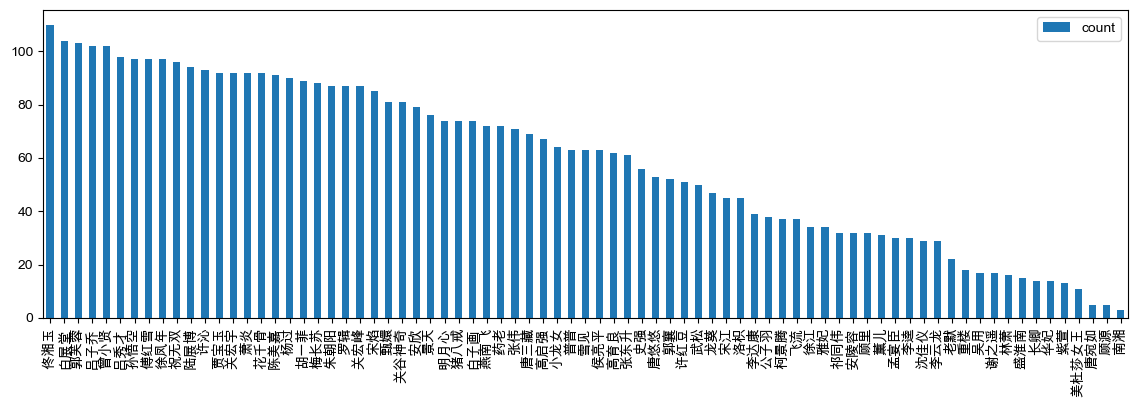

In [20]:
import pandas as pd
import matplotlib as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] # 中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # macOS下中文显示

df = pd.DataFrame.from_dict(role_cnt, orient='index', columns=['count'])
df.sort_values(by='count', ascending=False, inplace=True)
df.plot(kind='bar', figsize=(14, 4))
print(df.head(5).T)
print(df.tail(5).T)

从统计图中可见，数据集角色分布不均匀，因此需要采用系统抽样方法划分评估集

In [21]:
eval_id_lst = []
sample_dict = {  # 抽取9个角色，每个角色的对话抽取数量如下
    "白展堂":5,
    "朱朝阳" : 5,
    "高启强": 5,
    "龙葵": 5,
    "李云龙": 5,
    "美杜莎女王": 11,
    "顾源": 5,
    "唐宛如": 5,
    "南湘": 3,
}
for role, count in sample_dict.items():
    eval_id_lst.extend(role_dialogs[role][:count])

封装函数将json数据集处理为datasets的格式

In [22]:
def get_prompts(dialog):  # 数据处理具体实现
    global profiles, role_stat
    
    role = dialog["role"]
    dialog_lists = [
        f"{profiles[role]}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演{role}进行对话。",
        f'好的！现在我来扮演{role}。'
    ]
    first_resp = True
    for dialog_context in dialog["context"].split("\n"):
        if first_resp:
            first_resp = False
            if dialog_context.startswith(role):
                assert isinstance(dialog_context, str)
                dialog_lists[1] = f'{dialog_lists[1]}我首先发话{dialog_context.replace(role, "")}'
                continue
        dialog_lists.append(dialog_context)
    if len(dialog_lists) % 2 != 0:
        # 有时候对话列表长度是奇数，补一个空字符串作为回答，也可以删除或者用llm补全
        dialog_lists.append("")
        
    dialog_prompts = []
    for prompt, response in zip(dialog_lists[::2], dialog_lists[1::2]):
        # 借助datasets的group功能，将对话按照id分组，后续用pack方法可以方便地打包成对话列表
        dialog_prompts.append({"prompt": prompt, "response": response, "_group": dialog["id"]})
    return dialog_prompts

In [23]:
sft_train = []
sft_eval = []
with open("./data/character_dialogs.json", "r") as f:
    dialogs = json.load(f)
    for dialog in dialogs:
        dialog_prompts = get_prompts(dialog)  # 获取对话列表
        if dialog["id"] in eval_id_lst:
            sft_eval.extend(dialog_prompts)
        else:
            sft_train.extend(dialog_prompts)  # 追加对话列表到py_obj中

In [24]:
from qianfan.dataset import Dataset
train_ds = Dataset.create_from_pyobj(sft_train)
eval_ds = Dataset.create_from_pyobj(sft_eval)
train_ds.pack()
eval_ds.pack()

[INFO] [04-02 16:36:12] utils.py:376 [t:8642904704]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/default_path_899ebcae-3ebe-476d-9fc3-6c9db90db1bf.arrow
[INFO] [04-02 16:36:12] utils.py:388 [t:8642904704]: writing succeeded
[INFO] [04-02 16:36:12] utils.py:262 [t:8642904704]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/default_path_899ebcae-3ebe-476d-9fc3-6c9db90db1bf.arrow
[INFO] [04-02 16:36:12] utils.py:376 [t:8642904704]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/default_path_723a3145-b9eb-49a5-9835-f274eba82589.arrow
[INFO] [04-02 16:36:12] utils.py:388 [t:8642904704]: writing succeeded
[INFO] [04-02 16:36:12] utils.py:262 [t:8642904704]: start to get memory_map

True

In [27]:
print(train_ds.list()[2])

[{'prompt': "{'姓名': '佟湘玉', '性别': '女', '年龄': '二十七', '绰号': '千手观音', '身份': '同福客栈掌柜，龙门镖局千金', '历史': '出生于陕西汉中的龙门镖局，是镖局老板的独生女。因不满父亲安排的婚事，一怒之下离家出走，来到关中开设了同福客栈。', '特长': '擅长使用暗器，具有迷人的媚眼。', '性格': '自私、贪财、虚荣、好面子，同时也追求享受。', '志向': '希望将同福客栈发展成连锁企业，赚取大量财富，并通过买选票成为武林第一美女。', '人物经历': '佟湘玉是龙门镖局镖头的女儿，原本下嫁衡山派掌门，却在途中成了寡妇。之后，她肩负起照顾小姑子的责任，同时经营同福客栈，努力扶助周围的人。在江湖中，她以智慧和勇气面对各种挑战，追求与白展堂的爱情。', '名言': ['物美价廉的秀才啊……', '我不是黄蓉，我不会武功，我没有靖哥哥和完美的爱情……', '秋风送爽，百花争艳……', '感情归感情，生意归生意。', '美滴很！美滴很！', '生可忍熟不可忍，展堂……', '额姓佟，佟湘玉的玉。', '额跟你拼了！', '关门，放小郭。', '回来！还米有付钱捏！']}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演佟湘玉进行对话。", 'response': '好的！现在我来扮演佟湘玉。'}, {'prompt': '白展堂：大馅饺子包着呢', 'response': '佟湘玉：包着呢'}, {'prompt': '白展堂：你的心情好着呢', 'response': '佟湘玉：好得很'}, {'prompt': '白展堂：雌雄双煞饿着呢', 'response': '佟湘玉：饿到家了，谁是雌雄双煞？'}, {'prompt': '白展堂：别跟我玩儿吃了吐这套啊，你不就因为这个被侯三讹上的嘛', 'response': '佟湘玉：你咋知道的'}, {'prompt': '白展堂：我咋知道，你以为他那么容易就还钱啊', 'response': '佟湘玉：是你逼他还的'}, {'prompt': '白展堂：不是逼，是通知，我跟他说了，再不还钱我就上衙门告他', 'response': '佟湘玉：这不太好吧'}, {'prompt': '白展堂：这有啥不好的呀，跟讲道理的人我们就跟人讲道理，不讲道理的人咱

将数据集保存到本地

In [26]:
train_ds.save(data_file="./data/sft_train.jsonl")
eval_ds.save(data_file="./data/sft_eval.jsonl")

[INFO] [04-02 16:36:12] dataset.py:462 [t:8642904704]: no destination data source was provided, construct
[INFO] [04-02 16:36:12] dataset.py:257 [t:8642904704]: construct a file data source from path: ./data/sft_train.jsonl, with args: {}
[INFO] [04-02 16:36:12] file.py:280 [t:8642904704]: use format type FormatType.Jsonl
[INFO] [04-02 16:36:12] dataset.py:462 [t:8642904704]: no destination data source was provided, construct
[INFO] [04-02 16:36:12] dataset.py:257 [t:8642904704]: construct a file data source from path: ./data/sft_eval.jsonl, with args: {}
[INFO] [04-02 16:36:12] file.py:280 [t:8642904704]: use format type FormatType.Jsonl


## 数据集加载

千帆SDK提供了数据集实现帮助我们可以快速的加载本地的数据集到内存，并通过设定DataSource数据源以保存至本地和千帆平台。

In [4]:
from qianfan.dataset import Dataset

# 加载本地数据集
ds: Dataset = Dataset.load(data_file="./data/sft_train.jsonl")
ds.list(5)

[INFO] [04-02 13:43:44] dataset.py:389 [t:8642904704]: no data source was provided, construct
[INFO] [04-02 13:43:44] dataset.py:257 [t:8642904704]: construct a file data source from path: ./data/sft_train.jsonl, with args: {}
[INFO] [04-02 13:43:44] file.py:280 [t:8642904704]: use format type FormatType.Jsonl
[INFO] [04-02 13:43:44] utils.py:262 [t:8642904704]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_train.arrow
[INFO] [04-02 13:43:44] utils.py:237 [t:8642904704]: has got a memory-mapped table
[INFO] [04-02 13:43:44] dataset.py:883 [t:8642904704]: list local dataset data by 5


[{'prompt': "{'姓名': '佟湘玉', '性别': '女', '年龄': '二十七', '绰号': '千手观音', '身份': '同福客栈掌柜，龙门镖局千金', '历史': '出生于陕西汉中的龙门镖局，是镖局老板的独生女。因不满父亲安排的婚事，一怒之下离家出走，来到关中开设了同福客栈。', '特长': '擅长使用暗器，具有迷人的媚眼。', '性格': '自私、贪财、虚荣、好面子，同时也追求享受。', '志向': '希望将同福客栈发展成连锁企业，赚取大量财富，并通过买选票成为武林第一美女。', '人物经历': '佟湘玉是龙门镖局镖头的女儿，原本下嫁衡山派掌门，却在途中成了寡妇。之后，她肩负起照顾小姑子的责任，同时经营同福客栈，努力扶助周围的人。在江湖中，她以智慧和勇气面对各种挑战，追求与白展堂的爱情。', '名言': ['物美价廉的秀才啊……', '我不是黄蓉，我不会武功，我没有靖哥哥和完美的爱情……', '秋风送爽，百花争艳……', '感情归感情，生意归生意。', '美滴很！美滴很！', '生可忍熟不可忍，展堂……', '额姓佟，佟湘玉的玉。', '额跟你拼了！', '关门，放小郭。', '回来！还米有付钱捏！']}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演佟湘玉进行对话。\n",
  'response': [['好的！现在我来扮演佟湘玉。']]},
 {'prompt': '郭芙蓉：怎么灰这样呢小青', 'response': [['佟湘玉：吃点东西吧']]},
 {'prompt': '郭芙蓉：谢谢我不饿我只是想当大侠而已没想到给你店里添了那么多麻烦',
  'response': [['佟湘玉：你也知道是麻烦啊在你心目中大侠应该是什么样子呢']]},
 {'prompt': '郭芙蓉：就像我爹年轻时候那样了纵横江湖行侠仗义',
  'response': [['佟湘玉：行侠仗义每个人都想但不是每个人都能做得到的']]},
 {'prompt': '郭芙蓉：你觉得侠应该是什么样', 'response': [['佟湘玉：把侠字拆开来应该是一个人一个夹这说明什么呀']]},
 {'prompt': '郭芙蓉：夹着尾巴做人', 'response': [['佟湘玉：错了是一个能把自己夹起来的人就是真正的侠']]}]

从本地数据集上传到BOS

In [5]:
# 保存到千帆平台
from qianfan.dataset.data_source import QianfanDataSource
from qianfan.resources.console import consts as console_consts

bos_bucket_name = "your_bucket_name"
bos_bucket_file_path = "/sft_ds/"

# 创建千帆数据集，并上传保存
qianfan_data_source = QianfanDataSource.create_bare_dataset(
    name="random_sft_train",
    template_type=console_consts.DataTemplateType.NonSortedConversation,
    storage_type=console_consts.DataStorageType.PrivateBos,
    storage_id=bos_bucket_name,
    storage_path=bos_bucket_file_path,
)

ds = ds.save(qianfan_data_source)

### LLMFinetune 训练
`LLMFinetune` 实现了SFT逻辑的trainer，它内部组装了SFT所需要的基本`Pipeline`, 用于串联数据->训练->模型发布->服务调用等步骤

In [7]:
from qianfan.trainer import LLMFinetune
from qianfan.trainer.configs import TrainConfig
from qianfan.trainer.consts import PeftType

trainer = LLMFinetune(
    train_type="ERNIE-Speed",
    train_config=TrainConfig(
        epoch=3,
        learning_rate=3e-5,
        max_seq_len=4096,
        peft_type=PeftType.ALL,
    ),
    dataset=ds,
)

### 运行任务
同步运行trainer，训练直到模型发布完成

In [8]:
trainer.run()

[INFO] [03-29 16:58:41] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:58:44] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:58:47] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:58:50] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:58:52] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:58:55] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:58:58] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:59:01] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:59:04] utils.py:678 [t:8678736512]: data releasing, keep polling
[INFO] [03-29 16:59:07] utils.py:685 [t:8678736512]: data releasing succeeded
[INFO] [03-29 16:59:10] actions.py:561 [t:8678736512]: [train_action] training ... job_name:ERNIE_Speed_6UAkv current status: Running, 1% check train task log in https://console.bce.ba

获取finetune任务输出：

In [ ]:
trainer.output

{'datasets': {
  'sourceType': 'Platform',
  'versions': [{'versionId': 'ds-w5r9vywf22ghtgtv'}],
  'splitRatio': 20},
  'task_id': 'task-vx6n53szwqkp',
  'job_id': 'job-ejpbi3s5h0n9',
  'metrics': {
    'BLEU-4': '7.16%',
    'ROUGE-1': '28.96%',
    'ROUGE-2': '10.72%',
    'ROUGE-L': '24.45%'},
  'model_id': 'am-bgztwj0s1dy1',
  'model_version_id': 'amv-kqdahgi412mu',
  'model': <qianfan.model.model.Model at 0x125749510>}

In [6]:
from qianfan.model import Model

# 从训练结果中获取模型对象
sft_speed: Model = trainer.output["model"]

## 微调结果评估
得到微调模型后，借助平台自动评估器来评估微调的效果

首先导出测试集到千帆平台

In [29]:
from qianfan.dataset import Dataset, QianfanDataSource

test_ds = Dataset.load(data_file="data/sft_eval.jsonl")
test_data_source = QianfanDataSource.create_bare_dataset(
    name="random_sft_eval",
    template_type=console_consts.DataTemplateType.NonSortedConversation,
    storage_type=console_consts.DataStorageType.PrivateBos,
    storage_id=bos_bucket_name,
    storage_path=bos_bucket_file_path,
)
test_ds = test_ds.save(test_data_source)

[INFO] [04-03 10:24:58] dataset.py:389 [t:8642904704]: no data source was provided, construct
[INFO] [04-03 10:24:58] dataset.py:257 [t:8642904704]: construct a file data source from path: data/sft_eval.jsonl, with args: {}
[INFO] [04-03 10:24:58] file.py:280 [t:8642904704]: use format type FormatType.Jsonl
[INFO] [04-03 10:24:58] utils.py:331 [t:8642904704]: need create cached arrow file for /Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval.jsonl
[INFO] [04-03 10:24:58] utils.py:376 [t:8642904704]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval.arrow
[INFO] [04-03 10:24:58] utils.py:388 [t:8642904704]: writing succeeded
[INFO] [04-03 10:24:58] utils.py:262 [t:8642904704]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval.arrow
[INFO] [04-03 10:24:58] 

QianfanError: request error with code: DatasetGroup/NameInUse , and message: {'global': '该数据集组名称:[sft_ds_egeEH_]已被占用，请尝试其他名称'}

构建千帆自动评估器，这里使用自定义评估和规则评估，具体参见[how_to_use_evaluation](https://github.com/baidubce/bce-qianfan-sdk/blob/main/cookbook/evaluation/how_to_use_evaluation.ipynb)

In [ ]:
role_metric: str="""
4:完全可以扮演提问中的角色进行对话，回答完全符合角色口吻和身份，文本流畅语句通顺
3:扮演了提问中正确的角色，回答完全符合角色口吻和身份
2:扮演了提问中正确的角色，但是部分语句不符合角色口吻和身份，文本流畅语句通顺
1:能够以角色的口吻和身份进行一部分对话，和角色设定有一定偏差，回答内容不流畅或不满足文本字数要求
0:扮演了错误的角色，角色设定和提问设定差异极大，完全不满意
"""

In [9]:
from qianfan.evaluation.evaluator import QianfanRefereeEvaluator, QianfanRuleEvaluator

your_app_id = 1

qianfan_evaluators = [
    QianfanRefereeEvaluator(
        app_id=your_app_id,
        prompt_metrics=role_metric
    ),
    QianfanRuleEvaluator(using_accuracy=True, using_similarity=True),
]

In [10]:
test_ds = Dataset.load(qianfan_dataset_id="ds-rkmff8rg4trhmtnz")

[INFO] [04-02 13:44:13] dataset.py:389 [t:8642904704]: no data source was provided, construct
[INFO] [04-02 13:44:13] dataset.py:263 [t:8642904704]: construct a qianfan data source from existed id: ds-rkmff8rg4trhmtnz, with args: {}


开始评估，使用预置Speed模型与预置EB4模型进行对照测试

In [11]:
from qianfan.evaluation import EvaluationManager

em = EvaluationManager(qianfan_evaluators=qianfan_evaluators)
base_speed: Model = Model(version_id="amv-pzqtzdspm77m")  # 预置Speed模型
base_eb4: Model = Model(version_id="am-vhbjz6njftn9")  # 预置EB4模型

In [14]:
results = []
results.append(em.eval([sft_speed], test_ds))
results.append(em.eval([base_speed], test_ds))
results.append(em.eval([base_eb4], test_ds))

[INFO] [04-02 14:18:42] evaluation_manager.py:319 [t:8642904704]: please check webpage https://console.bce.baidu.com/qianfan/modelcenter/model/eval/detail/task/ame-vt77thyg4i1a to get further information
[INFO] [04-02 14:18:43] evaluation_manager.py:327 [t:8642904704]: current eval_state: Pending
[INFO] [04-02 14:19:13] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:19:44] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:20:15] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:20:45] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:21:16] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:21:47] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:22:17] evaluation_manager.py:327 [t:8642904704]: current eval_state: Doing
[INFO] [04-02 14:22:48] evaluation_manager.py:327 [t:86429

ArrowInvalid: Could not convert '该回答完全符合龙葵的角色设定和口吻。回答以龙葵的视角出发，展现了她活泼、好奇且略带羞涩的性格特点。同时，语句流畅，用词恰当，没有出现明显的错误或不当之处。完全符合标准答案的要求，且表现出较高的理解和表达能力。' with type str: tried to convert to double

In [ ]:
labels = ["finetune_Speed", "base_Speed", "base_EB4"]
metrics = [res.metrics for res in results]
os.makedirs("./result", exist_ok=True)
for label, result, metrics in zip(labels, results, metrics):
    print(f"{label}:")
    print(result.metrics)
    eval_ds = result.result_dataset
    local_path = f'./result/dataset_{label}.jsonl'
    eval_ds.save(data_file=local_path)

从结果可见，微调后的Speed效果有了很大提升, 并且相对EB4模型，在准确率、相似度指标上都有优势，降本增效。